In [5]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
from sdebridge.diffusion_bridge import DiffusionBridge
from sdebridge.sde import brownian_sde
from sdebridge.utils import score_fn
from sdebridge.data_processing import sample_ellipse

import matplotlib.pyplot as plt
import jax

In [7]:
T=1.
N=100
dim=2
num_pts = 5
sigma=1.0

forward_init = sample_ellipse(num_pts).flatten()
bm_sde = brownian_sde(T, N, dim, num_pts, sigma)
bm = DiffusionBridge(bm_sde)

In [8]:
key = jax.random.PRNGKey(2)
forward_trajs= bm.simulate_forward_process(forward_init, 2, key)

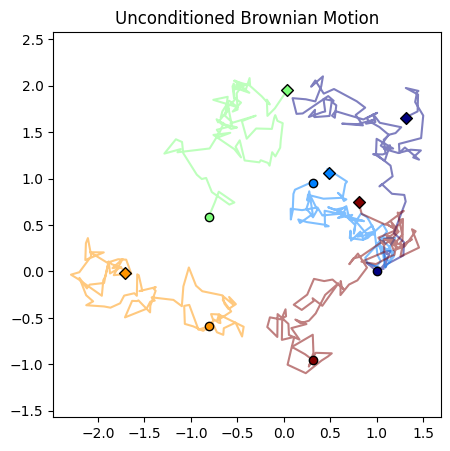

In [9]:
from sdebridge.plotting import plot_single_trajectory

traj = forward_trajs[0]
plot_single_trajectory(traj, "Unconditioned Brownian Motion")


In [10]:
from sdebridge.networks.score_mlp import ScoreMLP
setup_params = {
    "neural_net": ScoreMLP,
    "network": {
        "output_dim": bm.sde.dim*bm.sde.n_bases,
        "time_embedding_dim": 128,
        "init_embedding_dim": 256,
        "act_fn": "gelu",
        "encoder_layer_dims": [256, 256, 256],
        "decoder_layer_dims": [256, 256, 256],
        "batchnorm": False,
    },
    
    "training": {
        "batch_size": 100,
        "load_size": 1000,
        "num_epochs": 100,
        "num_batches_per_epoch": 10,
        "learning_rate": 1e-2,
        "warmup_steps": 0,
    }
}

target = sample_ellipse(num_pts).flatten()
train_key = jax.random.split(key, 2)[0]
score_state_p = bm.learn_p_score(target, train_key, setup_params)

Training: 100%|██████████| 100/100 [02:41<00:00,  1.61s/epoch, Epoch=100, loss=4.7040]


In [11]:
initial_val = sample_ellipse(num_pts, scale=1.2).flatten()
score_p = score_fn(score_state_p)
backward_trajs = bm.simulate_backward_bridge(initial_val, initial_val, score_p, 2, train_key)


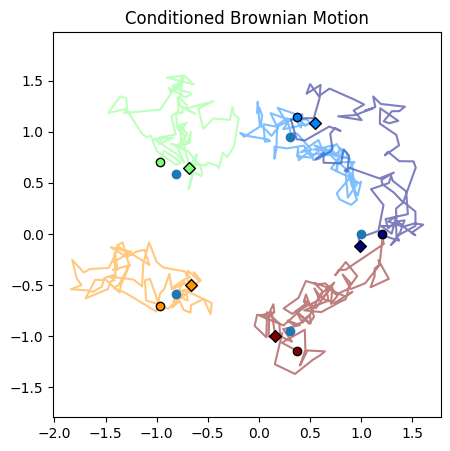

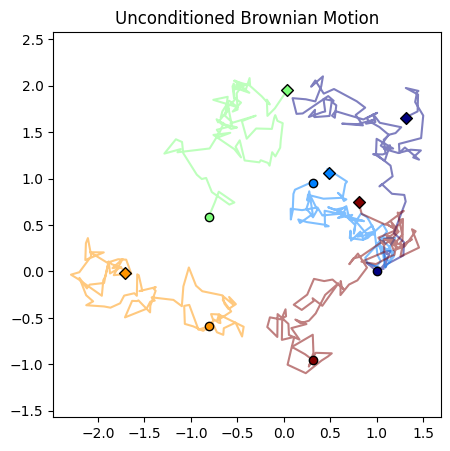

In [12]:
plt_init = forward_init.reshape((-1, 2))
traj = backward_trajs[0]
plot_single_trajectory(traj, "Conditioned Brownian Motion")
plt_target = target.reshape((num_pts, 2))
plt.scatter(plt_init[:, 0], plt_init[:, 1])
traj = forward_trajs[0]
plot_single_trajectory(traj, "Unconditioned Brownian Motion")